In [1]:
#region imports
import pandas as pd
import numpy as np
import missingno as msno
import random
import re
from nltk import word_tokenize
import re
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
stop_words = nltk.corpus.stopwords.words("english")
lemmatizer = WordNetLemmatizer()
from sklearn.feature_extraction.text import CountVectorizer


RANDOMSEED = 100
DISPLAY_WIDTH = 400
DISPLAYMAX_COLUMNS = 25
#endregion

#region settings
random.seed(RANDOMSEED)
pd.set_option('display.width', DISPLAY_WIDTH)
pd.set_option('display.max_columns', DISPLAYMAX_COLUMNS)
#endregion

In [3]:
df_awards=pd.read_csv("../data/220k_awards_by_directors.csv")
df_500_fav=pd.read_csv("../data/500 favorite directors_with wikipedia summary.csv", sep=";",header=0,names=['A', 'B'])
df_900_acc=pd.read_csv("../data/900_acclaimed_directors_awards.csv", sep=";")
df_all_casting=pd.read_csv("../data/AllMoviesCastingRaw.csv", sep=";")
df_all_details = pd.read_csv("../data/AllMoviesDetailsCleaned.csv", sep=";",low_memory=False)
df_lan2country_df = pd.read_csv('../data/language to country.csv')
df_most_common_lang=pd.read_csv("../data/MostCommonLanguageByDirector.csv")
df_spliberg=pd.read_csv("../data/spielberg_awards.csv",encoding='latin1')

In [4]:
def show(df_, rows=20, cols=30, title=None):
    if title:
        display(HTML(f'<h2 >{title}</h2 > '))
        with pd.option_context('display.min_rows', rows, 'display.max_columns', cols):
            display(df_)
    return df_

def get_var(df, var_name):
    globals()[var_name] = df
    return df

def tokenize(text):
    '''this method does the following
    1. normalizing all the words to lower size
    2. removes punctuations
    3. splits the words
    4. removes the stopwords like am,is,have,you,...
    5. lammetizes the words for example running-->run
    '''
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())    # normalize case and remove punctuation
    tokens = word_tokenize(text)    # tokenize text
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]    # lemmatize andremove stop words
    return tokens

def prep_data(text,method=CountVectorizer):
    '''
    this method counts either counts the words 
    in sentences (CountVectorizer) or wights them 
    based on their importance in the sentence 
    and entire data(TfidfVectorizer):
    '''
    count_vector = method(tokenizer=tokenize)
    count_vector.fit(text)
    doc_array = count_vector.transform(text).toarray()
    frequency_matrix_count = pd.DataFrame(doc_array, columns=count_vector.get_feature_names_out())
    return frequency_matrix_count



In [5]:
df=    (#1- major cleanups
    df_all_details  
        .query("status in ['Released']")
        .pipe(lambda df_:df_.replace("none",np.NaN))
        .assign(revenue=lambda df_:df_.revenue.replace(0,np.NAN),
            genres=lambda df_:df_.genres.fillna("none"),
            runtime=lambda df_:df_.runtime.fillna(-999),
            # original_language=lambda df_:df_.original_language.fillna("none"),
            day_of_week_temp=lambda df_:pd.to_datetime(df_.release_date,dayfirst=True),
            day_of_week=lambda f_:f_.day_of_week_temp.apply( lambda d:d.weekday()),
            year=lambda df_:pd.to_datetime(df_.release_date,dayfirst=True).dt.year,
            age=lambda df_:(2025-pd.to_datetime(df_.release_date,dayfirst=True).dt.year).fillna(-999),
            month=lambda df_:(pd.to_datetime(df_.release_date,dayfirst=True).dt.month),
            sin_month=lambda df_:(np.sin(2*np.pi*(df_.month-1)/12)).fillna(-999),
            cos_month=lambda df_:(np.cos(2*np.pi*(df_.month-1)/12)).fillna(-999),
            popularity=lambda df_:df_.popularity.apply(lambda x:x.replace(",","")).astype("float") ,
            original_language=lambda df_:df_.original_language.apply(lambda x:1 if x=="en" else 0),
            production_countries=lambda df_:df_.production_countries.apply(lambda x:1 if x=="United States of America" else 0),
            spoken_languages=lambda df_:df_.spoken_languages.apply(lambda x:1 if x=="English" else 0),
      
            )
        
        .dropna(subset="revenue")
        .query("revenue > 0")
        .reset_index(drop=True)
        .pipe(lambda df_:pd.concat([df_,
                                prep_data(df_.genres)],axis=1))
        .drop(columns=["imdb_id","original_title",
                    "overview","status","tagline","title","vote_average","vote_count",
                    "production_companies","release_date","day_of_week_temp"])
    
    )
actors_df=(#2- extracting actor_weights
            df_all_casting 
                .melt(id_vars="id",value_vars=["actor1_name","actor2_name","actor3_name","actor4_name","actor5_name"])
                .sort_values(by=["id","variable"])
                .merge(df[["id","year"]],on="id",how="left")
                .replace("none",np.NaN)
                .dropna()
                .assign(unit=1)
                .sort_values(by=["value","year"])
                .assign(actor_freq=lambda df_:df_.groupby("value").cumsum()["unit"])
                .pipe(lambda df_:pd.pivot(df_,values="actor_freq",columns="variable",index="id"))
                .reset_index()
            )
director_df=(#2- extracting director_weights
    df_all_casting 
                .melt(id_vars="id",value_vars=["director_name"])
                .sort_values(by=["id","variable"])
                .merge(df[["id","year"]],on="id",how="left")
                .replace("NaN",np.NaN)
                .replace("none",np.NaN)
                .dropna()
                .assign(unit=1)
                .sort_values(by=["value","year"])
                .assign(director_freq=lambda df_:df_.groupby("value").cumsum()["unit"])
                .drop(columns=["variable","value","year","unit"])
                .merge(df_all_casting[["id","director_name"]],on="id",how="left")
)

data_awards_cleaned=(
    df_awards
            .assign(outcome=lambda df_:df_["outcome"].replace(["2nd place", "3rd place"], "Won"))
            .groupby(["director_name", "year","outcome"])
            .count()
            .unstack()
            .fillna(0)
            .reset_index()
            .iloc[:,0:4]
            .pipe(lambda df_:pd.DataFrame(df_.values,columns=["director_name","year","nominated","won"]))
            .assign(nominated_cumsum = lambda df_: df_.groupby("director_name")["nominated"].transform(pd.Series.cumsum),
                won_cumsum = lambda df_: df_.groupby("director_name")["won"].transform(pd.Series.cumsum),
                )
            .set_index(["director_name","year"])
)
    

def fame_func(director,dt_,stat=0):

    try: 
        if stat==0:
            return data_awards_cleaned.loc[director][data_awards_cleaned.loc[director].index<=dt_].tail(1).nominated_cumsum.values[0]
        else:
            return data_awards_cleaned.loc[director][data_awards_cleaned.loc[director].index<=dt_].tail(1).won_cumsum.values[0]
            
    except:
        return np.NaN

df=(
    df
    .merge(actors_df,on=['id'],how="left")
    .merge(director_df,on=['id'],how="left")
    .drop(columns=["id","genres","spoken_languages_number"] )
).assign(
    fame_nominated= lambda df_:df_.apply(lambda df_:fame_func(df_.director_name,df_.year),axis=1),
    fame_won= lambda df_:df_.apply(lambda df_:fame_func(df_.director_name,df_.year,stat=1),axis=1)
    
).drop(columns=["director_name","fiction","year"] )


df_nulls=df.replace(-999,np.NAN)
df

/home/aaquib/.pyenv/versions/.pde_cap/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,budget,original_language,popularity,production_countries,revenue,runtime,spoken_languages,production_companies_number,production_countries_number,day_of_week,age,month,...,thriller,tv,war,western,actor1_name,actor2_name,actor3_name,actor4_name,actor5_name,director_freq,fame_nominated,fame_won
0,4000000,1,1.698000,1,4300000.0,98.0,1,2,1,0.0,30.0,12.0,...,0,0,0,0,3.0,8.0,5.0,7.0,3.0,2.0,4.0,4.0
1,0,1,1.322870,0,12136938.0,110.0,1,3,2,4.0,32.0,10.0,...,1,0,0,0,8.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0
2,11000000,1,10.492614,1,775398007.0,121.0,1,2,1,2.0,48.0,5.0,...,0,0,0,0,1.0,3.0,1.0,2.0,6.0,3.0,6.0,3.0
3,94000000,1,9.915573,1,940335536.0,100.0,1,1,1,4.0,22.0,5.0,...,0,0,0,0,4.0,1.0,1.0,19.0,1.0,2.0,9.0,8.0
4,55000000,1,10.351236,1,677945399.0,142.0,1,1,1,2.0,31.0,7.0,...,0,0,0,0,14.0,3.0,2.0,3.0,13.0,8.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8652,200,0,0.141433,0,200.0,-999.0,0,1,1,0.0,8.0,6.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
8653,1000,1,0.017510,1,700.0,10.0,0,1,3,0.0,9.0,6.0,...,0,0,0,0,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN
8654,800000,0,0.009000,0,40000.0,-999.0,0,0,1,NaN,-999.0,NaN,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8655,0,0,0.096195,0,640691.0,108.0,0,3,1,3.0,9.0,12.0,...,0,0,0,0,NaN,NaN,1.0,2.0,2.0,2.0,5.0,17.0


<AxesSubplot:>

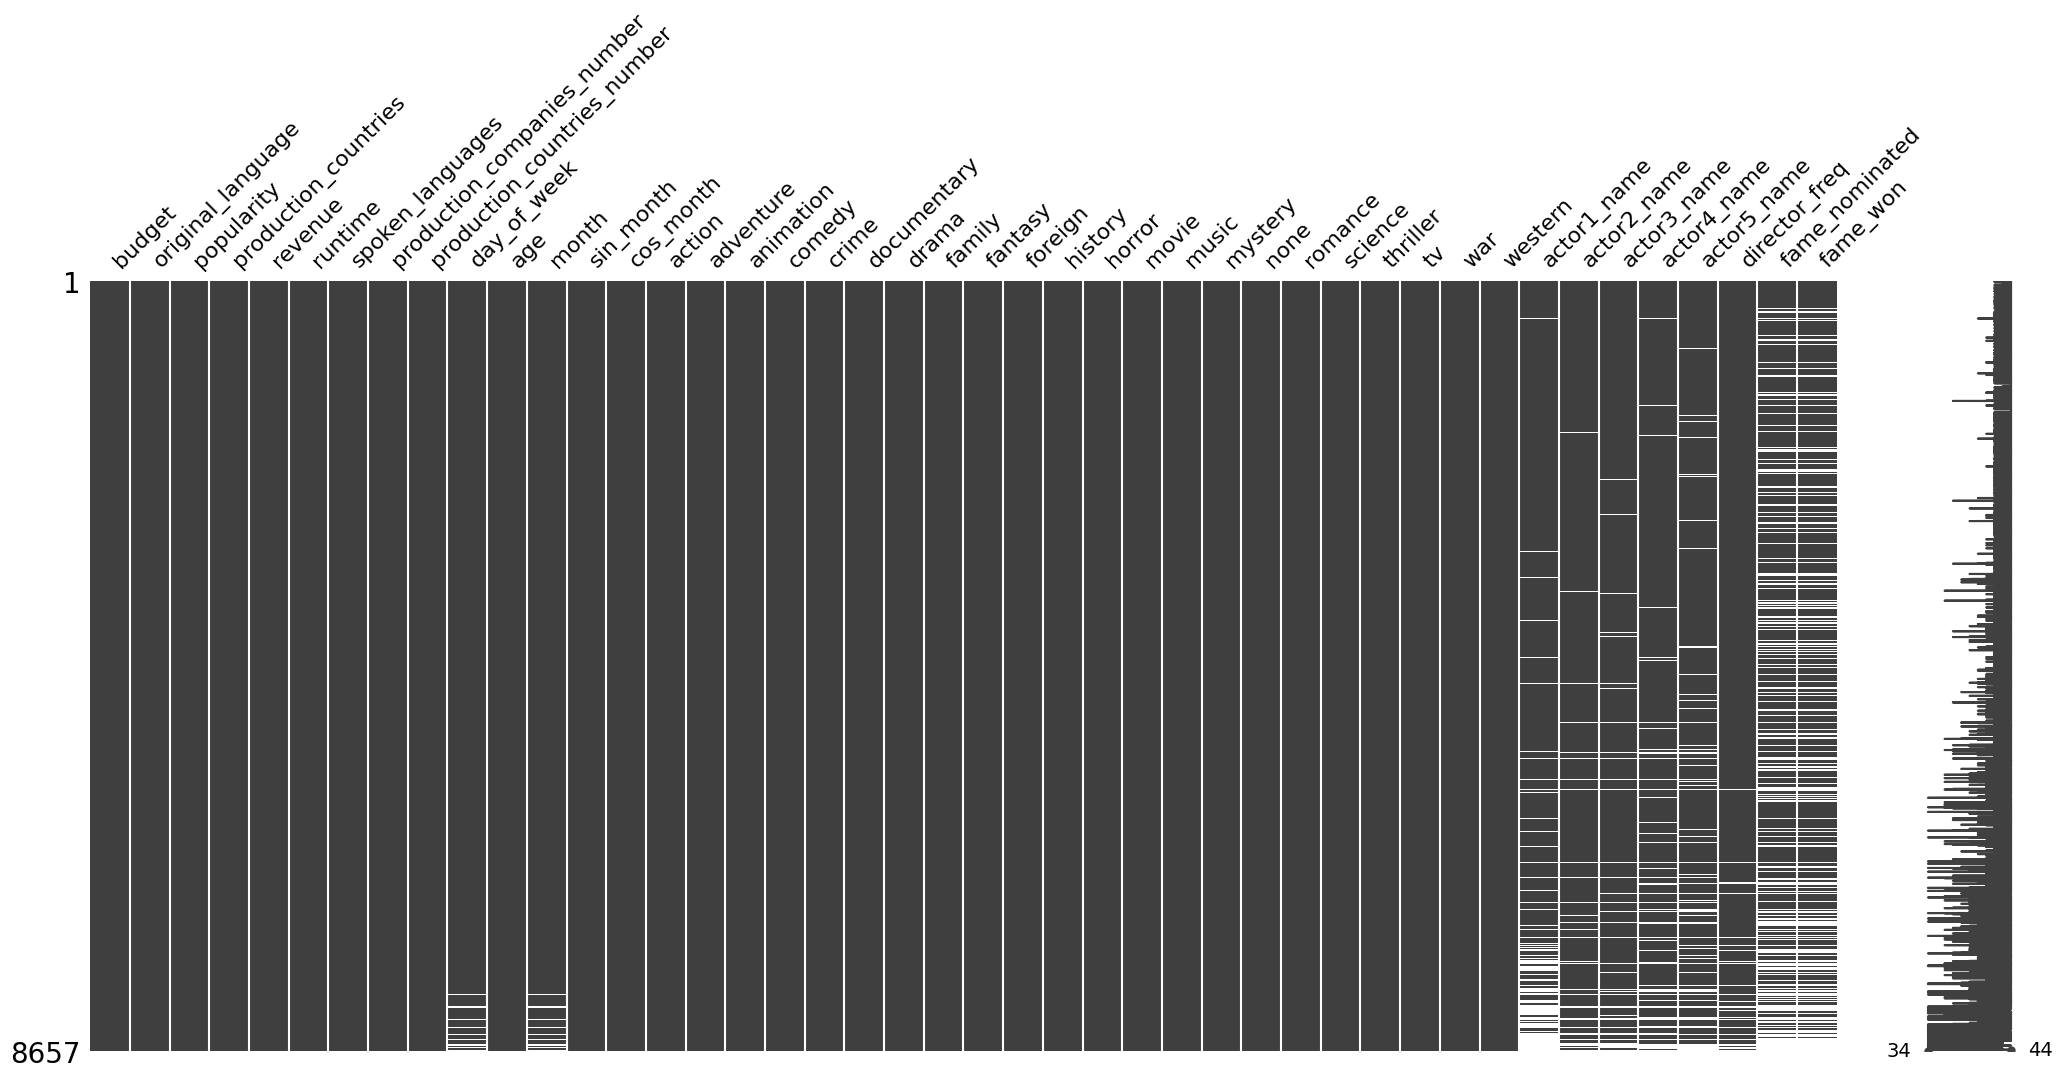

In [6]:
msno.matrix(df)

<AxesSubplot:>

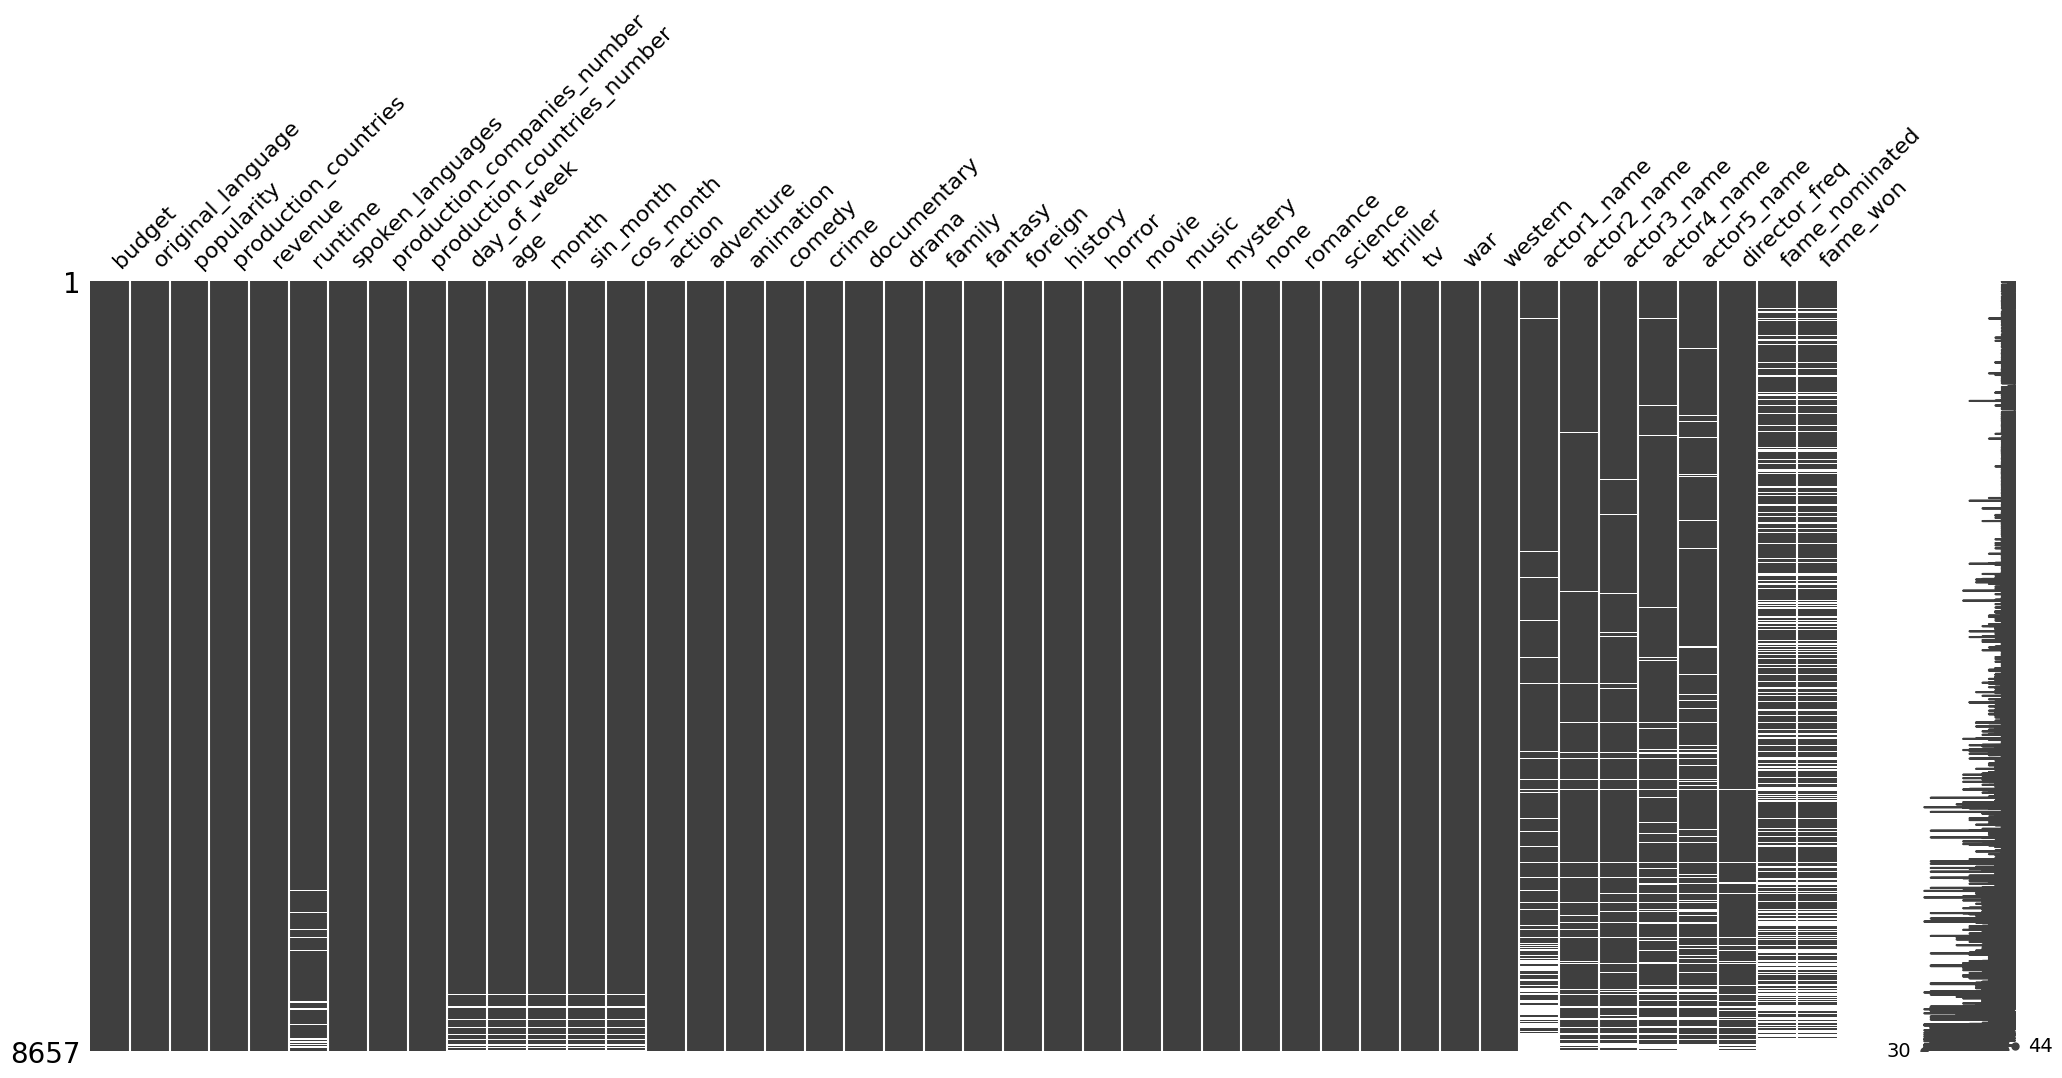

In [7]:
msno.matrix(df_nulls)

In [8]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import Ridge
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator

from sklearn.impute import SimpleImputer,KNNImputer

from sklearn import set_config

set_config(display="diagram")

from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
import lightgbm as lgbm


In [9]:
# X=df_nulls.drop(columns=["revenue","popularity"])
X=df.drop(columns=["revenue","popularity"])
y=df[["revenue","popularity"]]

In [10]:
cat_transformer = Pipeline([
    ("ohc",OneHotEncoder(handle_unknown='ignore'))
    ])
preprocessor = ColumnTransformer([
('cat_tr', cat_transformer, ['day_of_week']),
('cat_imputer', SimpleImputer(strategy="most_frequent"), ['day_of_week','actor1_name', 'actor2_name', 
                                                          'actor3_name', 'actor4_name', 'actor5_name', 
                                                          'director_freq', 'fame_nominated', 'fame_won']),
('imputer',SimpleImputer(strategy="median"),["runtime",'age', 'sin_month', 'cos_month'])

]
,remainder="passthrough")
m=Pipeline([
        # ('preprocessor',preprocessor),
        # ('imputer',KNNImputer())
        # ('scaler',StandardScaler()),
        # ("estimator",XGBRegressor())
        ("estimator",lgbm.LGBMRegressor())
        
    ])
m

Pipeline(steps=[('estimator', LGBMRegressor())])

In [11]:
cross_val_score(m, X, y.iloc[:,0], cv=3)

array([0.40249539, 0.58734319, 0.66834596])

In [12]:
from sklearn.ensemble import BaggingRegressor
reg=BaggingRegressor(base_estimator=m,n_estimators=20,max_features=35,random_state=0,bootstrap_features=True)

In [13]:
cross_val_score(reg, X, y.iloc[:,0], cv=5).mean()

0.5540781397837375

In [14]:
df.original_language.value_counts().head(12)

1    6922
0    1735
Name: original_language, dtype: int64

In [15]:
df.spoken_languages.value_counts()

1    6033
0    2624
Name: spoken_languages, dtype: int64

In [16]:
df_all_details.columns

Index(['id', 'budget', 'genres', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'vote_average', 'vote_count', 'production_companies_number', 'production_countries_number', 'spoken_languages_number'], dtype='object')

In [17]:
df

,budget,original_language,popularity,production_countries,revenue,runtime,spoken_languages,production_companies_number,production_countries_number,day_of_week,age,month,...,thriller,tv,war,western,actor1_name,actor2_name,actor3_name,actor4_name,actor5_name,director_freq,fame_nominated,fame_won
0,4000000,1,1.698000,1,4300000.0,98.0,1,2,1,0.0,30.0,12.0,...,0,0,0,0,3.0,8.0,5.0,7.0,3.0,2.0,4.0,4.0
1,0,1,1.322870,0,12136938.0,110.0,1,3,2,4.0,32.0,10.0,...,1,0,0,0,8.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0
2,11000000,1,10.492614,1,775398007.0,121.0,1,2,1,2.0,48.0,5.0,...,0,0,0,0,1.0,3.0,1.0,2.0,6.0,3.0,6.0,3.0
3,94000000,1,9.915573,1,940335536.0,100.0,1,1,1,4.0,22.0,5.0,...,0,0,0,0,4.0,1.0,1.0,19.0,1.0,2.0,9.0,8.0
4,55000000,1,10.351236,1,677945399.0,142.0,1,1,1,2.0,31.0,7.0,...,0,0,0,0,14.0,3.0,2.0,3.0,13.0,8.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8652,200,0,0.141433,0,200.0,-999.0,0,1,1,0.0,8.0,6.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
8653,1000,1,0.017510,1,700.0,10.0,0,1,3,0.0,9.0,6.0,...,0,0,0,0,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN
8654,800000,0,0.009000,0,40000.0,-999.0,0,0,1,NaN,-999.0,NaN,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8655,0,0,0.096195,0,640691.0,108.0,0,3,1,3.0,9.0,12.0,...,0,0,0,0,NaN,NaN,1.0,2.0,2.0,2.0,5.0,17.0


In [18]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [23]:
y.iloc[:0]

,revenue,popularity


In [34]:
reg.fit(X, y.iloc[:, 0])
result = permutation_importance(
    reg, X, y.iloc[:,0], n_repeats=11, random_state=42, n_jobs=2
)

<Figure size 1500x1000 with 0 Axes>

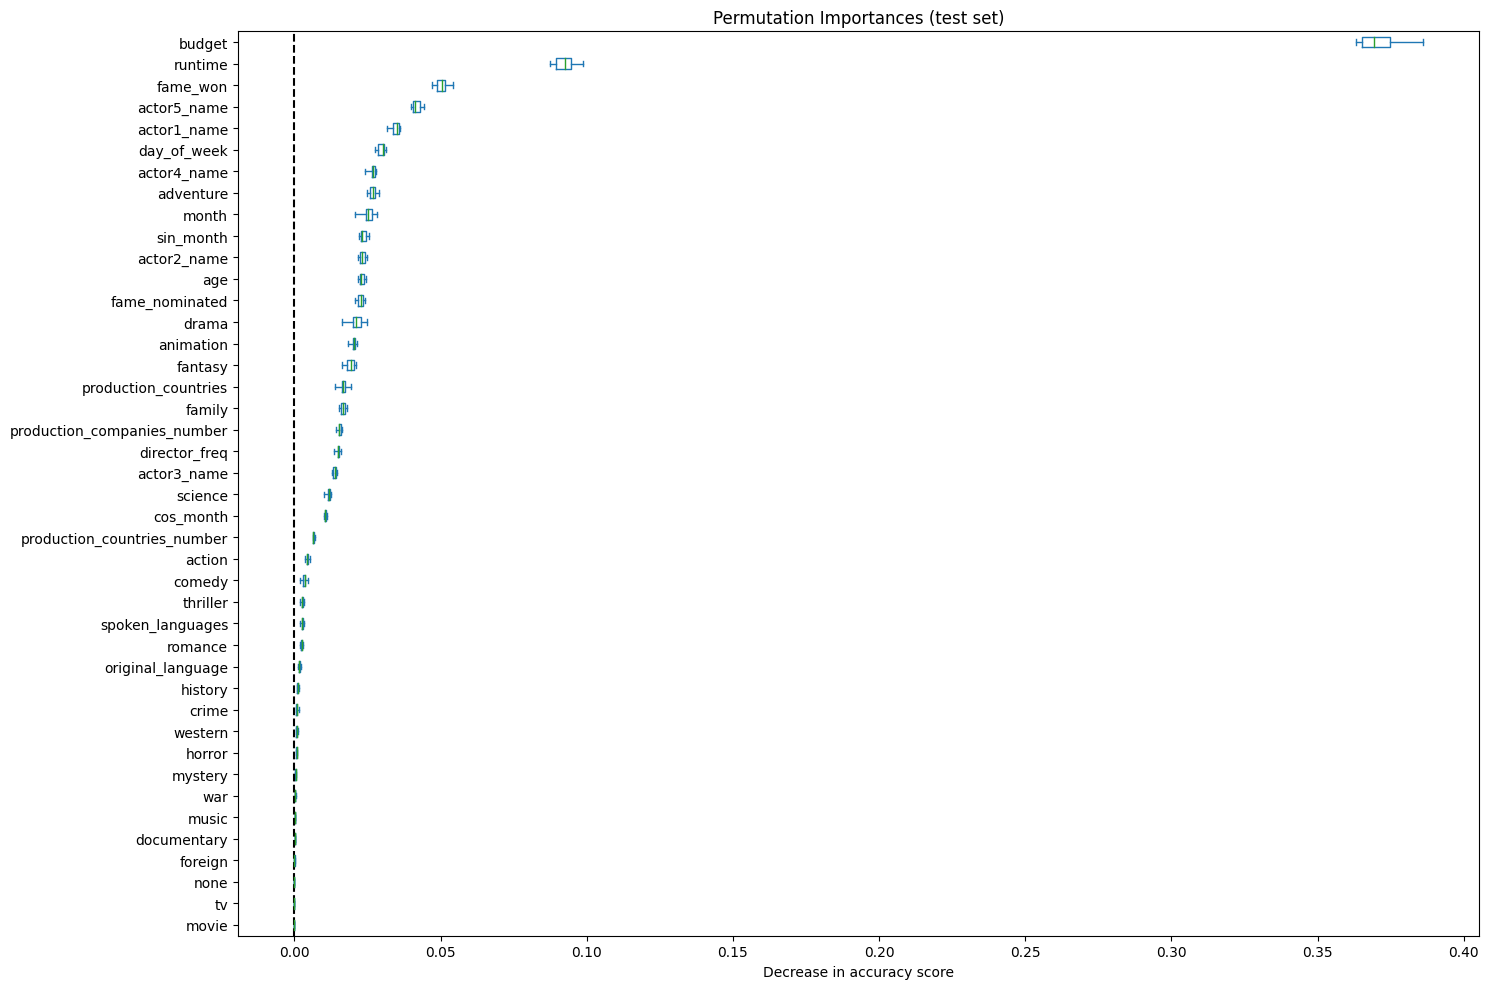

In [35]:
plt.figure(figsize=(15,10))
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10, figsize = (15,10))
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

In [323]:
import requests
import json
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import time

In [10]:
# url = "https://api.themoviedb.org/3/movies/details?api_key=769b44db6b985f2709498795599362ac"

In [147]:
# url = "https://api.themoviedb.org/3/movie/343611?api_key=769b44db6b985f2709498795599362ac"
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page="+"200"

# https://api.themoviedb.org/3/movie/{movie_id}?api_key=<<api_key>>&language=en-US

In [148]:
url

'https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=200'

In [149]:
response = requests.get(url)
type(response.content)

bytes

In [150]:
soup = response.json()

In [157]:
check = pd.DataFrame(soup["results"])
check.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   adult              20 non-null     bool   
 1   backdrop_path      20 non-null     object 
 2   genre_ids          20 non-null     object 
 3   id                 20 non-null     int64  
 4   original_language  20 non-null     object 
 5   original_title     20 non-null     object 
 6   overview           20 non-null     object 
 7   popularity         20 non-null     float64
 8   poster_path        20 non-null     object 
 9   release_date       20 non-null     object 
 10  title              20 non-null     object 
 11  video              20 non-null     bool   
 12  vote_average       20 non-null     float64
 13  vote_count         20 non-null     int64  
dtypes: bool(2), float64(2), int64(2), object(8)
memory usage: 2.0+ KB


In [160]:
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page="+"100"
response = requests.get(url)
soup = response.json()
check.append(soup["results"]).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 0 to 19
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   adult              40 non-null     bool   
 1   backdrop_path      40 non-null     object 
 2   genre_ids          40 non-null     object 
 3   id                 40 non-null     int64  
 4   original_language  40 non-null     object 
 5   original_title     40 non-null     object 
 6   overview           40 non-null     object 
 7   popularity         40 non-null     float64
 8   poster_path        40 non-null     object 
 9   release_date       40 non-null     object 
 10  title              40 non-null     object 
 11  video              40 non-null     bool   
 12  vote_average       40 non-null     float64
 13  vote_count         40 non-null     int64  
dtypes: bool(2), float64(2), int64(2), object(8)
memory usage: 4.1+ KB


/tmp/ipykernel_3154/3879279332.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  check.append(soup["results"]).info()


In [325]:

df = pd.DataFrame(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=101"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=102"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=103"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=104"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=105"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=106"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=107"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=108"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=109"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=110"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=111"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=112"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=113"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=114"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=115"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=116"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=117"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=118"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=119"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=120"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=121"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=122"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=123"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=124"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=125"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=126"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=127"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=128"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=129"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=130"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=131"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=132"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=133"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=134"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=135"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=136"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=137"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=138"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=139"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=140"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=141"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=142"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=143"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=144"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=145"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=146"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=147"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=148"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=149"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=150"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=151"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=152"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=153"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=154"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=155"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=156"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=157"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=158"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=159"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=160"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=161"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])
url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=162"
response = requests.get(url)
soup = response.json()
df = df.append(soup["results"])

In [182]:
# for i in range(101, 110):
#     url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page="+str(i)
#     print(url)
#     # time.sleep(3)
#     # response = requests.get(url)
#     # soup = response.json()
#     # df.append(soup["results"])

https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=101
https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=102
https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=103
https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=104
https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=105
https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=106
https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=107
https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=108
https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page=109


In [327]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1260 entries, 0 to 19
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   adult              1260 non-null   bool   
 1   backdrop_path      1219 non-null   object 
 2   genre_ids          1260 non-null   object 
 3   id                 1260 non-null   int64  
 4   original_language  1260 non-null   object 
 5   original_title     1260 non-null   object 
 6   overview           1260 non-null   object 
 7   popularity         1260 non-null   float64
 8   poster_path        1256 non-null   object 
 9   release_date       1256 non-null   object 
 10  title              1260 non-null   object 
 11  video              1260 non-null   bool   
 12  vote_average       1260 non-null   float64
 13  vote_count         1260 non-null   int64  
dtypes: bool(2), float64(2), int64(2), object(8)
memory usage: 130.4+ KB


In [333]:
df1 = df[["id", "release_date", "title", "vote_average", "vote_count"]]
df1["release_date"] = pd.to_datetime(df1["release_date"])
df1["year"] = df1["release_date"].dt.year
df2 = df1[(df1["year"]<2020) & (df1["year"]>2017)]
df2 = df2.sort_values(by=["year", "vote_average"], ascending = False)

In [334]:
df2

,id,release_date,title,vote_average,vote_count,year
3,656958,2019-07-05,Room Salon College Girls 2,10.0,1,2019.0
2,572154,2019-06-15,Rascal Does Not Dream of a Dreaming Girl,8.3,410,2019.0
12,537061,2019-09-02,Steven Universe: The Movie,8.3,698,2019.0
12,515001,2019-10-18,Jojo Rabbit,8.1,7937,2019.0
8,556901,2019-07-21,Teen Titans Go! vs. Teen Titans,7.9,395,2019.0
...,...,...,...,...,...,...
18,385448,2018-08-02,The Little Mermaid,5.0,781,2018.0
8,860314,2018-04-26,My Friend's Nice Mother 2,5.0,1,2018.0
17,439015,2018-08-10,Slender Man,4.4,1706,2018.0
19,554447,2018-05-28,A Female Employee's Taste,3.5,2,2018.0


In [310]:
url = "https://api.themoviedb.org/3/movie/338970?api_key=769b44db6b985f2709498795599362ac&language=en-US"
response = requests.get(url)
soup1 = response.json()

In [312]:
url = "https://api.themoviedb.org/3/movie/338970/credits?api_key=769b44db6b985f2709498795599362ac&language=en-US"
response = requests.get(url)
soup2 = response.json()

In [313]:
for i in range(5):
    if soup2["cast"][i]["known_for_department"] == "Acting":
        print(soup2["cast"][i]["name"])

Alicia Vikander
Dominic West
Walton Goggins
Daniel Wu
Kristin Scott Thomas


In [314]:
for i in range(len(soup2["crew"])):
    if soup2["crew"][i]["job"]=="Director":
        print(soup2["crew"][i]["original_name"])

Roar Uthaug


In [ ]:
import requests
import json
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import time

url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page="+"100"
response = requests.get(url)
soup = response.json()
df = pd.DataFrame(soup["results"])
for i in range(101, 110):
    url = "https://api.themoviedb.org/3/movie/popular?api_key=769b44db6b985f2709498795599362ac&language=en-US&page="+str(i)
    print(url)
    time.sleep(3)
    response = requests.get(url)
    soup = response.json()
    df.append(soup["results"])
df1 = df[["id", "release_date", "title"]]
df1["release_date"] = pd.to_datetime(df1["release_date"])
df1["year"] = df1["release_date"].dt.year
df2 = df1[(df1["year"]<2020) & (df1["year"]>1993)]
df2 = df2.sort_values(by="year", ascending = False)
url = "https://api.themoviedb.org/3/movie/338970?api_key=769b44db6b985f2709498795599362ac&language=en-US"
response = requests.get(url)
soup1 = response.json()
url = "https://api.themoviedb.org/3/movie/338970/credits?api_key=769b44db6b985f2709498795599362ac&language=en-US"
response = requests.get(url)
soup2 = response.json()
for i in range(5):
    if soup2["cast"][i]["known_for_department"] == "Acting":
        print(soup2["cast"][i]["name"])
for i in range(len(soup2["crew"])):
    if soup2["crew"][i]["job"]=="Director":
        print(soup2["crew"][i]["original_name"])

In [322]:
import json
import requests
import csv
import datetime
import os

filename = "allmoviesdetails.csv"

#retrieve API KEY
# api_key_file = "apikey.txt"
# with open(api_key_file, "r") as filehandle:
#     api_key =  next(csv.reader(filehandle))[0]

nbofreq = 0
request = "https://api.themoviedb.org/3/movie/latest?api_key="+"769b44db6b985f2709498795599362ac"

# Si le fichier n'existe pas on le crée et initialise les headers
if not os.path.isfile(filename):
    with open(filename, "w") as filehandle:
        writer = csv.writer(filehandle, delimiter=';', lineterminator='\n')
        querystring = "https://api.themoviedb.org/3/movie/15?api_key=" + "769b44db6b985f2709498795599362ac"
        req_details = requests.get(querystring)
        dic_details = json.loads(req_details.text)
        headers = list()
        for key in dic_details:
            headers.append(key)
        # on ajoute les headers nb companies, countries & languages
        headers.append("production_companies_number")
        headers.append("production_countries_number")
        headers.append("spoken_languages_number")
        writer.writerow(headers)
        print(str(datetime.datetime.now().time()) + " : headers")

# Sinon on l'ouvre (en lecture) pour trouver le dernier ID
with open(filename, "r", encoding='utf-8') as filehandle:
    reader=csv.reader(filehandle)
    for row in reader:
            try:
                rowlist = row[0].split(";")
                rowcount = rowlist[6]
                #print(rowcount)
            except:
                pass


# Puis on l'ouvre en écriture pour le remplir
with open(filename, "a", encoding='utf-8') as filehandle:

    # Récupération de l'index du dernier film dispo sur tmdb
    querystring = "https://api.themoviedb.org/3/movie/latest?api_key="+"769b44db6b985f2709498795599362ac"
    req_details = requests.get(querystring)
    dic_details = json.loads(req_details.text)
    latest_tmdb_movie_index = dic_details["id"]
    rowcount=int(rowcount)
    # On récupère et stocke chaque film entre {nb de lignes déjà dans le fichier} et {latest movie}
    while rowcount < latest_tmdb_movie_index:
        writer = csv.writer(filehandle, delimiter=';', lineterminator='\n')
        querystring = "https://api.themoviedb.org/3/movie/" + str(rowcount) + "?api_key=" + "769b44db6b985f2709498795599362ac"
        req_details = requests.get(querystring)
        dic_details = json.loads(req_details.text)
        print(str(datetime.datetime.now().time()) + " : fetching details for id " + str(rowcount))

        # on fabrique la liste "rateau" des détails du film
        # genres : on garde tout mais on concatène
        # production_companies : on ne garde que la 1ere + le nombre
        # production_countries : on ne garde que la 1ere + le nombre
        # spoken_languages : on ne garde que la 1ere + le nombre
        liste_details = list()

        production_companies_number = 0
        production_countries_number = 0
        spoken_languages_number = 0

        # Si la 1ere clé est status code = 34 alors pas de données => on écrit l'Id et on passe au suivant
        for key in dic_details:
            if key == "status_code":
                liste_details.append(rowcount)
                break
            elif key == "genres":
                genres = ""
                for genre_temp in dic_details[key]:
                    genres += genre_temp["name"] + "|"
                genres = genres[:-1]
                liste_details.append(genres)
            elif key == "production_companies":
                if len(dic_details[key]) > 0:
                    production_companies = dic_details[key][0]["name"]
                else:
                    production_companies = "none"
                liste_details.append(production_companies)
                production_companies_number = len(dic_details[key])
            elif key == "production_countries":
                if len(dic_details[key]) > 0:
                    production_countries = dic_details[key][0]["name"]
                else:
                    production_countries = "none"
                liste_details.append(production_countries)
                production_countries_number = len(dic_details[key])
            elif key == "spoken_languages":
                if len(dic_details[key]) > 0:
                    spoken_languages = dic_details[key][0]["name"]
                else:
                    spoken_languages = "none"
                liste_details.append(spoken_languages)
                spoken_languages_number = len(dic_details[key])
            else:
                liste_details.append(dic_details[key])

        liste_details.append(production_companies_number)
        liste_details.append(production_countries_number)
        liste_details.append(spoken_languages_number)

        writer.writerow(liste_details)

        try:
            print(str(datetime.datetime.now().time()) + " : " + dic_details["title"] + " (id=" + str(rowcount) + ")")
        except KeyError:
            print(str(datetime.datetime.now().time()) + " : Ghost id (id=" + str(rowcount) + ")")

        rowcount += 1

TypeError: '<' not supported between instances of 'str' and 'int'